# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [10]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch, decimate
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [11]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    mat = sio.loadmat(file_path)
    data = {
        'signal': mat['Signal'].squeeze(),
        'flashing': mat['Flashing'].squeeze(),
        'stimulus_code': mat['StimulusCode'].squeeze()
    }

    # Training data has labels, test data doesn't
    if 'StimulusType' in mat:
        data['stimulus_type'] = mat['StimulusType'].squeeze()
    else:
        data['stimulus_type'] = None

    if 'TargetChar' in mat:
        # Flatten the MATLAB array to 1D
        raw_tc = mat['TargetChar'].ravel()
        # Extract target character from MATLAB file (handle string/byte formats safely)
        if isinstance(raw_tc[0], (str, bytes)):
            data['target_char'] = ''.join(
                ch.decode() if isinstance(ch, bytes) else ch
                for ch in raw_tc
            )
        else:
            data['target_char'] = None
    else:
        data['target_char'] = None

    return data

def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    row_idx = row_code - 1
    col_idx = col_code - 7
    return CHAR_MATRIX[row_idx, col_idx]

In [12]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low,high], btype='band')
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal, axis=0)

def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline = np.mean(epoch[:baseline_samples, :], axis=0)
    return epoch - baseline

def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor=original_fs//target_fs
    return signal[::factor,:]

def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    peak_to_peak = np.ptp(signal, axis=0)
    return np.all(np.abs(peak_to_peak) < threshold)

def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """

    # Convert to microvolts
    signal = data['signal'].copy() / 1e6

    if apply_bandpass:
        signal = bandpass_filter(signal, fs=fs)
    if apply_notch:
        signal = notch_filter(signal, fs=fs)

    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data.get('stimulus_type', None)

    if apply_downsample:
        factor = fs // 60
        signal = signal[:, ::factor, :]
        flashing = flashing[:, ::factor]
        stimulus_code = stimulus_code[:, ::factor]
        if stimulus_type is not None:
            stimulus_type = stimulus_type[:, ::factor]
        fs = 60

    out = {
        'signal': signal,
        'flashing': flashing,
        'stimulus_code': stimulus_code,
        'fs': fs
    }
    if stimulus_type is not None:
        out['stimulus_type'] = stimulus_type

    return out

def extract_epochs(data, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs

    Returns: Dictionary with epochs, labels, codes, character indices
    """
    signal = data['signal']
    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data.get('stimulus_type', None)

    samples_per_epoch = int(epoch_length_ms * fs / 1000)
    baseline_samples = int(0.2 * fs)

    epochs = []
    labels = []
    codes_list = []
    char_idx_list = []

    # average reference
    signal = signal - signal.mean(axis=2, keepdims=True)

    # Loop over trials
    for trial_idx in range(signal.shape[0]):
        f = np.rint(flashing[trial_idx]).astype(int)
        c = stimulus_code[trial_idx].astype(int)
        st = stimulus_type[trial_idx] if stimulus_type is not None else None

        # Rising edges: 0 → 1
        onsets = np.where((f[1:] == 1) & (f[:-1] == 0))[0] + 1

        for idx in onsets:
            if idx - baseline_samples < 0 or idx + samples_per_epoch > signal.shape[1]:
                continue

            # Extract epoch after stimulus onset
            epoch = signal[trial_idx, idx:idx + samples_per_epoch, :]

            # Baseline correction using pre-stimulus window
            baseline = signal[trial_idx, idx - baseline_samples:idx, :].mean(axis=0)
            epoch -= baseline

            epochs.append(epoch)
            codes_list.append(c[idx])
            labels.append(st[idx] if st is not None else None)
            char_idx_list.append((trial_idx, idx))

    return {
        'epochs': np.array(epochs),
        'labels': np.array(labels),
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list),
        'fs': fs
    }

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    epochs = np.asarray(epoch_data['epochs'])
    labels = np.asarray(epoch_data['labels'])

    # Select channel
    target_epochs = epochs[labels == 1, :, channel_idx]
    nontarget_epochs = epochs[labels == 0, :, channel_idx]

    time_ms = np.arange(epochs.shape[1]) * 1000 / fs

    # Average across trials (ERP)
    erp_target = target_epochs.mean(axis=0)
    erp_nontarget = nontarget_epochs.mean(axis=0)

    # Plot ERP waveforms
    plt.figure(figsize=(8, 4))
    plt.plot(time_ms, erp_target, label="Target", linewidth=2)
    plt.plot(time_ms, erp_nontarget, label="Non-Target", linewidth=2)

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"ERP at Channel {channel_idx}")
    plt.legend()
    plt.grid(True)

    # Highlight expected P300 window
    plt.axvspan(250, 450, color="lightblue", alpha=0.3)

    plt.show()

    # Compute simple P300 amplitude difference metric
    p300_window = (time_ms >= 300) & (time_ms <= 500)
    return np.max(erp_target[p300_window]) - np.max(erp_nontarget[p300_window])


In [13]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    n_epochs, n_samples, n_channels = epochs.shape
    return epochs.reshape(n_epochs, n_samples * n_channels)

def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
    """
    X = extract_time_domain_features(epochs)
    pca = PCA(n_components=n_components, whiten=True, random_state=42)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    # Compute covariance matrices
    def compute_cov(data):
        cov = np.zeros((data.shape[2], data.shape[2]))
        for epoch in data:
            c = np.cov(epoch.T)
            cov += c / np.trace(c)
        return cov / len(data)

    cov_target = compute_cov(target_epochs)
    cov_nontarget = compute_cov(non_target_epochs)

    # Solve generalized eigenvalue problem
    eigvals, eigvecs = np.linalg.eig(
        np.linalg.pinv(cov_nontarget).dot(cov_target)
    )

    # Sort by eigenvalues
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    # Select most discriminative components (extreme eigenvalues)
    W = np.hstack([
        eigvecs[:, :n_components // 2],
        eigvecs[:, -n_components // 2:]
    ])
    projected = np.array([epoch @ W for epoch in epochs])

    # Extract CSP features (log variance)
    features = np.log(np.var(projected, axis=1))

    return features, W


def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    Returns: (features, transformer_object) where transformer_object is None for 'time_domain'.
    """
    epochs = epoch_data['epochs']
    labels = epoch_data.get('labels', None)

    if method == 'time_domain':
        return extract_time_domain_features(epochs), None

    elif method == 'pca':
        X, pca = extract_pca_features(epochs, n_components)
        return X, pca

    elif method == 'csp':
        if labels is None:
            raise ValueError("CSP requires labels")
        X, W = extract_csp_features(epochs, labels, n_components)
        csp_transformer = CSPTransformer(n_components=n_components)
        csp_transformer.W = W
        return X, csp_transformer

def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """
    model = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
    model.fit(X_train, y_train)
    return model


def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    )
    model.fit(X_train, y_train)
    return model


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    y_pred = model.predict(X_test)

    print(f"\n=== {model_name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n",
          classification_report(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        print("ROC AUC:", roc_auc_score(y_test, y_prob))

class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, n_components=6):
        self.n_components = n_components
        self.W = None

    def fit(self, epochs, labels):
        _, self.W = extract_csp_features(
            epochs, labels, self.n_components
        )
        return self

    def transform(self, epochs):
        projected = np.array([epoch @ self.W for epoch in epochs])
        return np.log(np.var(projected, axis=1))


In [14]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    model = SVC(
        kernel=kernel,
        C=C,
        class_weight='balanced',
        probability=True,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model, scaler

def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """
    print(f"\n  Training Random Forest (n_estimators={n_estimators})...")

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    (GradientBoosting doesn't support class_weight parameter)
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    """
    y_train = y_train.astype(int)

    class_counts = np.bincount(y_train)
    total = len(y_train)
    weights = total / (2 * class_counts)
    sample_weights = weights[y_train]

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model


def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """

    results = []

    #SVM
    svm, scaler = train_svm_classifier(X_train, y_train)
    X_test_scaled = scaler.transform(X_test)
    y_pred = svm.predict(X_test_scaled)

    #Random Forest
    rf = train_random_forest(X_train, y_train)
    y_pred = rf.predict(X_test)
    results.append({
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

    # Gradient Boosting
    gb = train_gradient_boosting(X_train, y_train)
    y_pred = gb.predict(X_test)
    results.append({
        "Model": "Gradient Boosting",
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })
    models = {}
    models["SVM"] = (svm, scaler)
    models["Random Forest"] = rf
    models["Gradient Boosting"] = gb

    # Summary
    print("\n=== Classical Model Comparison ===")
    for r in results:
        print(f"{r['Model']:20s} | Accuracy={r['Accuracy']:.4f} | F1={r['F1']:.4f}")

    return results, models

def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [15]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive
    import os

    drive.mount('/content/drive')
    DATA_PATH = '/content/bci2004/BCI_Comp_III_Wads_2004/'
    if not os.path.exists(DATA_PATH):
      !unzip /content/drive/MyDrive/BCI_Comp_III_Wads_2004.zip -d /content/bci2004

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [17]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_proc_A)
    test_epochs_A = extract_epochs(test_proc_A)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_proc_B)
    test_epochs_B = extract_epochs(test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---

--- Subject B ---



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---


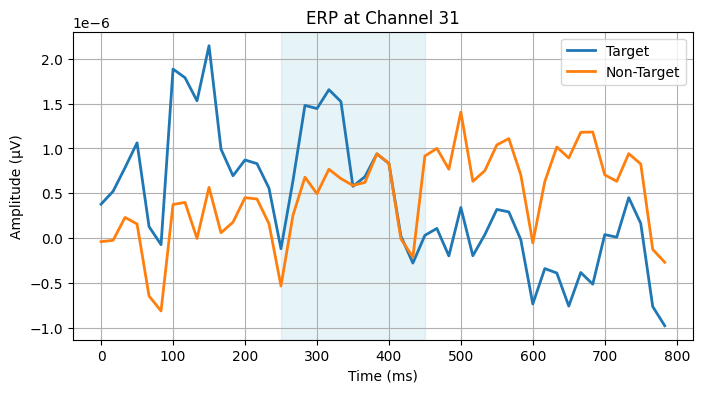

np.float64(2.5038633056374864e-07)

In [18]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=31)

In [19]:
# ========================================================================
# STEP 5: FEATURE EXTRACTION
# ========================================================================
print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)

# ========================================================================
# Subject A: Compare PCA vs CSP vs Time-Domain
# ========================================================================
print("\n--- Subject A: Feature Comparison ---")

y_A = train_epochs_A['labels']

# PCA (20 components)
X_pca20_A, pca20_A = extract_pca_features(
    train_epochs_A['epochs'], n_components=20
)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_pca20_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_va)
acc_pca20 = accuracy_score(y_va, y_pred)
f1_pca20 = f1_score(y_va, y_pred)

# PCA (50 components)
X_pca50_A, pca50_A = extract_pca_features(
    train_epochs_A['epochs'], n_components=50
)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_pca50_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_va)
acc_pca50 = accuracy_score(y_va, y_pred)
f1_pca50 = f1_score(y_va, y_pred)

# CSP (6 components)
X_csp_A, W_csp_A = extract_csp_features(
    train_epochs_A['epochs'], y_A, n_components=6
)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_csp_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_va)
acc_csp = accuracy_score(y_va, y_pred)
f1_csp = f1_score(y_va, y_pred)

# Time-Domain (raw)
X_time_A = train_epochs_A['epochs'].reshape(
    len(train_epochs_A['epochs']), -1
)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_time_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_va)
acc_time = accuracy_score(y_va, y_pred)
f1_time = f1_score(y_va, y_pred)


# ========================================================================

print("\n" + "="*70)
print("FEATURE COMPARISON (Balanced Classifiers)")
print("="*70)
print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

# Select best method based on F1-score
scores = {
    'pca': f1_pca20,
    'csp': f1_csp,
    'time': f1_time
}

feature_method_A = max(scores, key=scores.get)
print(f"\nSelected feature method for Subject A: {feature_method_A.upper()}")

if feature_method_A == 'pca':
    X_train_full_A = X_pca20_A
    feature_obj_A = pca20_A
    n_components_A = 20

elif feature_method_A == 'csp':
    X_train_full_A = X_csp_A
    feature_obj_A = CSPTransformer(n_components=6)
    feature_obj_A.W = W_csp_A

else:  # time
    X_train_full_A = X_time_A
    feature_obj_A = None

  # ========================================================================
# Subject A: Create final train/val split for later steps
# ========================================================================
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
)
print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data
if feature_method_A == 'time':
    X_test_A = test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)
elif feature_method_A == 'pca':
    X_test_A = feature_obj_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))
else:  # CSP
    X_test_A = feature_obj_A.transform(test_epochs_A['epochs'])

print(f"Test features: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
print("\n--- Subject B: Feature Extraction ---")
print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

if feature_method_A == 'time':
    X_train_full_B = train_epochs_B['epochs'].reshape(len(train_epochs_B['epochs']), -1)
    X_test_B = test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)
elif feature_method_A == 'pca':
    X_train_full_B, pca_B = extract_features(train_epochs_B, method='pca', n_components=n_components_A)
    X_test_B = pca_B.transform(test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1))
else:  # CSP
    X_train_full_B, csp_B = extract_features(train_epochs_B, method='csp', n_components=6)
    X_test_B = csp_B.transform(test_epochs_B['epochs'])

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels']
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")


print(f"\nSubject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
print(f"Test features: {X_test_B.shape}")

# Store feature objects for later use



STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---
  Target epochs for CSP: 2523
  Non-target epochs for CSP: 12607

FEATURE COMPARISON (Balanced Classifiers)
PCA (20 comp):      Accuracy=0.4960, F1=0.2477
PCA (50 comp):      Accuracy=0.5169, F1=0.2425
CSP (6 comp):       Accuracy=0.5238, F1=0.2491
Time-Domain (3072): Accuracy=0.6157, F1=0.1895

Selected feature method for Subject A: CSP

Subject A splits: Training=12104, Validation=3026
Test features: (17800, 6)

--- Subject B: Feature Extraction ---

Using CSP (same as Subject A)...
  Target epochs for CSP: 2523
  Non-target epochs for CSP: 12607
Subject B splits: Training=12104, Validation=3026, Test features: (17800, 6)

Subject B splits: Training=12104, Validation=3026
Test features: (17800, 6)


In [20]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")



STEP 6: BASELINE CLASSIFIERS (Subject A)

=== LDA Evaluation ===
Accuracy: 0.5237937871777925
Confusion Matrix:
 [[1346 1175]
 [ 266  239]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.53      0.65      2521
         1.0       0.17      0.47      0.25       505

    accuracy                           0.52      3026
   macro avg       0.50      0.50      0.45      3026
weighted avg       0.72      0.52      0.58      3026

ROC AUC: 0.5241531531177711

=== Logistic Regression Evaluation ===
Accuracy: 0.5270984798413747
Confusion Matrix:
 [[1352 1169]
 [ 262  243]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.54      0.65      2521
         1.0       0.17      0.48      0.25       505

    accuracy                           0.53      3026
   macro avg       0.50      0.51      0.45      3026
weighted avg       0.73      0.53      0.59      3026

ROC AUC: 0.526

In [ ]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)

    results_classical_A, models_A = compare_all_classical_models(
        X_train_A, y_train_A, X_val_A, y_val_A
    )

    # Train SVM for both subjects (best model)
    svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
    svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)


In [ ]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'scaler': scaler_A,
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'scaler': scaler_B,
    }, 'models/subject_B_svm.pkl')

